### 0.Imports and setups

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('20200124_ews_observations.csv',sep = ',',
                low_memory=False,index_col=1,parse_dates=[1])

In [3]:
df.head()

,PatientId,EwsProcedure,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,Add_O2,Add_O2_Score,HR,HR_Score,RR,RR_Score,TEMP,TEMP_Score
ObservationDate,,,,,,,,,,,,,,,,,
2019-05-01 13:27:50,29,NEWS2,0,143.0,0.0,ALERT,0,96.0,0.0,False,0.0,80,0,18,0,36.6,0
2019-05-01 15:27:44,30,NEWS2,3,NaN,NaN,ALERT,0,94.0,1.0,False,0.0,83,0,16,0,36.5,0
2019-05-01 15:54:27,31,NEWS2,1,117.0,0.0,ALERT,0,95.0,1.0,False,0.0,75,0,14,0,37.3,0
2019-05-01 16:07:27,32,NEWS2,0,NaN,NaN,ALERT,0,98.0,0.0,False,0.0,85,0,19,0,37.2,0
2019-05-01 17:03:16,33,NEWS2,0,135.0,0.0,ALERT,0,97.0,0.0,False,0.0,89,0,14,0,36.1,0


### 1. Selecting a Patient for modelling

In [4]:
patient = df[df.PatientId == 1743]

In [5]:
patient.index = pd.DatetimeIndex(patient.index).to_period('D')

In [6]:
patient.dropna(inplace=True)

In [7]:
patient.isnull().sum()

PatientId       0
EwsProcedure    0
EWS_Total       0
SBP             0
SBP_Score       0
LOC             0
LOC_Score       0
SpO2            0
SpO2_Score      0
Add_O2          0
Add_O2_Score    0
HR              0
HR_Score        0
RR              0
RR_Score        0
TEMP            0
TEMP_Score      0
dtype: int64

# 2. Stationarity Check

### 2.1 visual plots

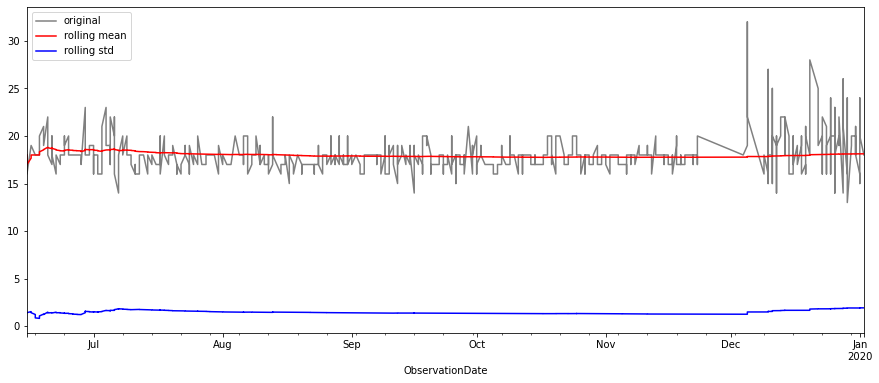

In [8]:
original = patient.RR.plot(color='gray',label='original')
rolling_mean = patient.RR.rolling(window='D').mean().plot(color='red',label='rolling mean')
rolling_std = patient.RR.rolling(window='D').std().plot(color='blue',label='rolling std')
plt.legend()

### 2.2 Dickey-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller
def adf(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [21]:
adf(patient.RR)

Results of Dickey-Fuller Test:


Test Statistic                  -3.694734
p-value                          0.004188
#Lags Used                      15.000000
Number of Observations Used    600.000000
Critical Value (1%)             -3.441296
Critical Value (5%)             -2.866369
Critical Value (10%)            -2.569342
dtype: float64

# 3 Selecting Model 
## 3.0 ACF and PACF plots:

In [22]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(patient.RR, nlags=50)
lag_pacf = pacf(patient.RR, nlags=50, method='ols')

### 3.1 Plotting ACF 'AutoCorrelationFunction'

Text(0.5, 1.0, 'Autocorrelation Function')

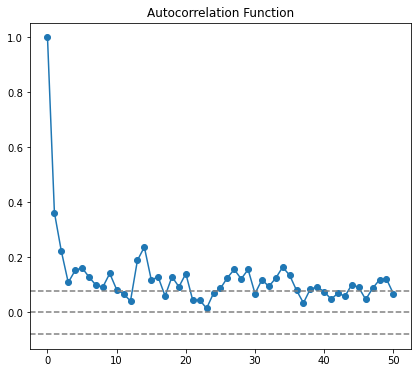

In [23]:
plt.subplot(121) 
plt.plot(lag_acf,marker='o')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(patient.RR)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(patient.RR)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

### 3.2 Plotting PACF 'PartialCorrelationFunction'

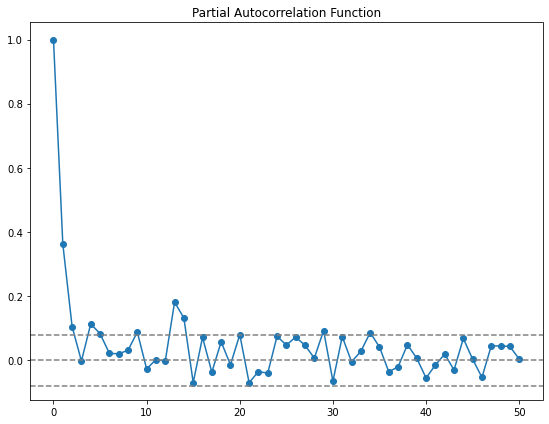

In [24]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, marker='o')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(patient.RR)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(patient.RR)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# 4 Arima Model

### 4.0 Grid 'AIC' search for potential (p,q) 

In [25]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = ARIMA(patient.RR, order=(p,0,q))
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan

In [26]:
aic_full

,0,1,2,3,4,5
0,0.000000,2492.617867,2469.540681,2471.249970,2470.985023,2468.495835
1,2471.465924,2465.691125,2456.391684,NaN,NaN,NaN
2,2466.684760,2468.152927,2469.464609,NaN,NaN,NaN
3,2468.680879,2469.994948,2451.235502,2451.160601,NaN,NaN
4,2462.935354,2450.677182,2451.907115,2453.089745,2443.083307,2456.143554
5,2460.869369,2450.879881,2452.560272,2443.057941,2459.110431,2449.472468


Text(0.5, 1.0, 'RMSE: 1.7377')

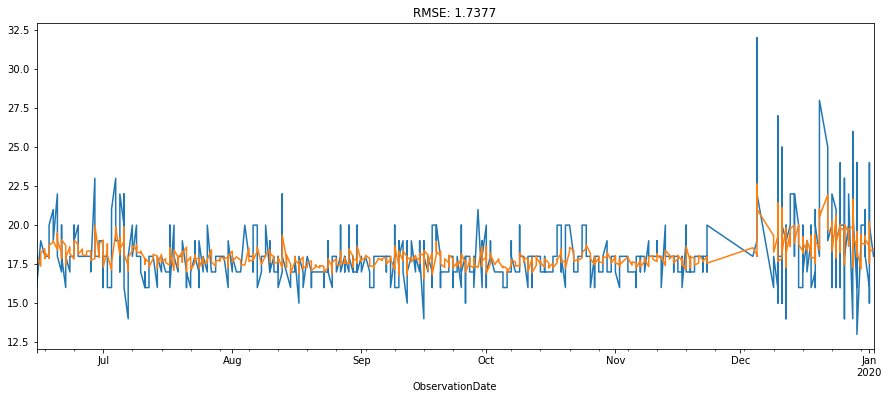

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
model = ARIMA(patient.RR, order=(4, 0, 4)) 
results_AR = model.fit()  
patient.RR.plot()
results_AR.fittedvalues.plot()
plt.title('RMSE: %.4f'% sqrt(mean_squared_error(patient.RR,results_AR.fittedvalues)))

### Testing Train Vs Test

Test RMSE: 2.484


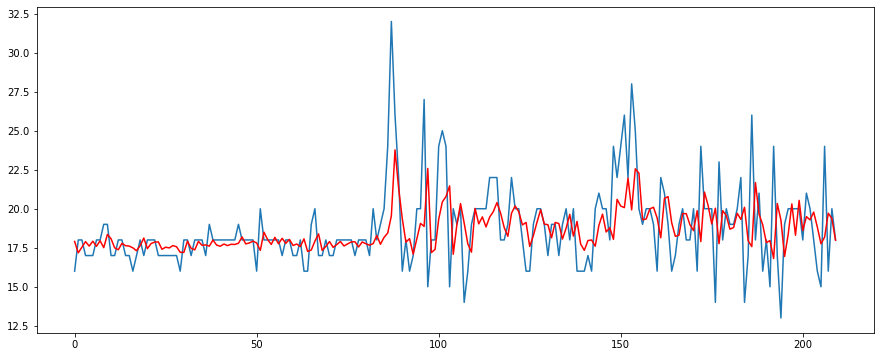

In [29]:
X = patient.RR.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()